In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import time
import scipy.optimize as optimize
import math

In [2]:
# read movement data
with open("data/movements/a=3 b=1 p=0.025 gam=1.5/sample_movements.pkl", "rb") as file:
    movements = pkl.load(file)
print(movements.shape)
# get weather
with open("data/weather_crawl_all.pkl", "rb") as file:
    weather = pkl.load(file)
    
# conver weather into dictionary form
w_data = {}
for tp_loc in weather:
    tp_w = {}
    for tp_ym in weather[tp_loc]:
        for tp_data in weather[tp_loc][tp_ym]:
            tp_dt = tp_data['ds'].replace("年",",").replace("月",",").replace("日",",").split(",")
            tp_t = int(tp_data['ts'][:-1])
            tp_key = (int(tp_dt[0]), int(tp_dt[1]), int(tp_dt[2]), tp_t)
            tp_w[tp_key] = tp_data
    w_data[tp_loc] = tp_w
    
# read data
with open("data/boundary.pkl", "rb") as file:
    dis_bd = pkl.load(file)

locs = []
for tp_dis in dis_bd:
    locs.append(tp_dis)

(5000000, 184)


In [14]:
with open("data/district_population.pkl", "rb") as file:
    dis_pop = pkl.load(file)
    
with open("data/boundary.pkl", "rb") as file:
    dis_bd = pkl.load(file)
    
locs = []
for tp_dis in dis_bd:
    locs.append(tp_dis)
pops = np.array([dis_pop[tp_dis] for tp_dis in locs])

In [3]:
temperature_M = np.zeros((len(locs), movements.shape[1]-37))-1
humidity_M = np.zeros((len(locs), movements.shape[1]-37))-1
yms = [(2021,9), (2021,10), (2021,11), (2021,12), (2022,1)] # year and month
month_days = {(2021,9):(7,30), (2021,10):(1,31), 
              (2021,11):(1,30), (2021,12):(1,31), (2022,1):(1,31)} # numebr of days in each month
time_ex = [0, 6, 12, 18]
for i in range(len(locs)):
    tp_loc = locs[i]
    tp_dict = weather[tp_loc]
    tp_ct = 0 # count for the index of temperature/humidity matrix
    for tp_ym in yms:
        for tp_d in range(month_days[tp_ym][0], month_days[tp_ym][1]+1):
            tp_temp = 0
            tp_hum = 0
            for tp_t in time_ex:
                tp_key = (tp_ym[0], tp_ym[1], tp_d, tp_t)
                if w_data[tp_loc][tp_key]["desc"] == "No weather data available":
                    tp_temp = -100000
                    tp_hum = -100000
                    break
                else:
                    tp_temp += w_data[tp_loc][tp_key]["temp"]
                    tp_hum += w_data[tp_loc][tp_key]["temp"]
            tp_temp /= 4
            tp_hum /= 4
            temperature_M[i][tp_ct] = tp_temp
            humidity_M[i][tp_ct] = tp_temp
            tp_ct += 1
            
# interpolate temperature and humidity
for i in range(temperature_M.shape[1]):
    temp_index = (temperature_M[:, i]<-300)
    hum_index = (humidity_M[:, i]<-300)
    temperature_M[temp_index, i] = temperature_M[(temp_index==False),i].mean()
    humidity_M[hum_index, i] = humidity_M[(hum_index==False),i].mean()

In [4]:
print((temperature_M<0).sum())
print((humidity_M<0).sum())

0
0


In [5]:
# read estimated infections
with open("data/estimated_infection_bdis_bday.pkl", "rb") as file:
    infections = pkl.load(file)
    
# process infections into matrix
# the average for one week on 9/7
tp_time_tx = "2021/9/"
inf_dates = [tp_time_tx+str(i) for i in range(4,11)]
initial_infections = np.array([sum([infections[tp_loc][tp_dt] for tp_dt in inf_dates])/len(inf_dates) for tp_loc in locs])

In [6]:
initial_infections

array([ 1.08468874,  1.08468874,  6.92564678,  9.76219868,  3.02223913,
        1.05775326,  1.86815283,  1.41070427,  0.        ,  2.32794433,
        2.90672893,  0.49083945,  4.45900688,  5.65682713,  8.33129362,
        3.41532325,  6.50813245, 14.58196266, 10.4030451 ,  5.82897346,
        9.16446978,  3.70982132,  5.42344371,  5.599281  ,  3.2303465 ,
        2.31106945,  2.39451747,  2.16937748,  1.73779545,  1.00383134,
        3.74345135,  2.23362693,  0.        ,  4.85699402,  5.94319081,
        3.15603954,  3.40585209,  1.75398229,  0.10707512,  4.35455356,
        3.00476033,  2.61190242,  5.10589403,  2.41088357,  0.70647188,
        1.99893869,  2.85674476,  1.65506381,  4.71328552,  8.02237772,
       13.78351937,  7.55552546, 23.86315233,  5.21337124, 21.69377484])

In [8]:
pts = [[10.54,0.07585], [10.76,0.09169], [15.3, 0.03608], [16.52, 0.03266], [20.05, 0.04216], [21.79, 0.03718], [25.64, 0.03043],
      [27.64, 0.02709], [31.33, 0.04391], [31.65, 0.03417], [32.55, 0.04438], [33.41, 0.04983]]
real = np.array(pts)
x = real[:, 0]
y = real[:, 1]
def base_func(x, b0, b1, b2, b3, b4):
    y = b0 + b1*x + b2*x**2 + b3*x**3 + b4*x**4
    return y

cf = optimize.curve_fit(f=base_func, xdata=x, ydata=y, p0=[1,1,1,1,1])

In [9]:
cf[0]

array([ 8.59455846e-01, -1.53928039e-01,  1.05994167e-02, -3.18278157e-04,
        3.51061475e-06])

In [18]:
# defined the functions for time-varying variables
E_v_a = lambda T: 0.131-0.05723*T+0.01164*T**2-0.001341*T**3+0.00008723*T**4 - 0.000003017*T**5 + 5.153*10**(-8)*T**6 - 3.42*10**(-10)*T**7
U_v_a = lambda T: 2.13 - 0.3797*T + 0.02457*T**2 - 0.0006778*T**3 + 0.000006794*T**4
U_v_v = lambda T: 0.8595 - 0.1539*T + 0.01060*T**2 - 0.0003183*T**3 + 0.000003511*T**4
theta_v_v = lambda T: -5.4 + 1.8*T - 0.2124*T**2 + 0.01015*T**3 - 0.0001515*T**4
def r_v_v(T):
    K = T+273.15
    R = 1.987
    inc = 0.003359*K/298*np.exp((15000/R*(1/298-
                                          1/K)))/(1+np.exp(6.203*10**21/R*
                                                           (1/(-2.176*10**30)-1/K)))
    return inc*24

phi_hu_to_vec = lambda T: 0.001044*T*(T-12.286)*(32.461-T)**0.5 # this can be negative!
phi_vec_to_hu = lambda T: 0.0729*T - 0.97 # this is a bit weird

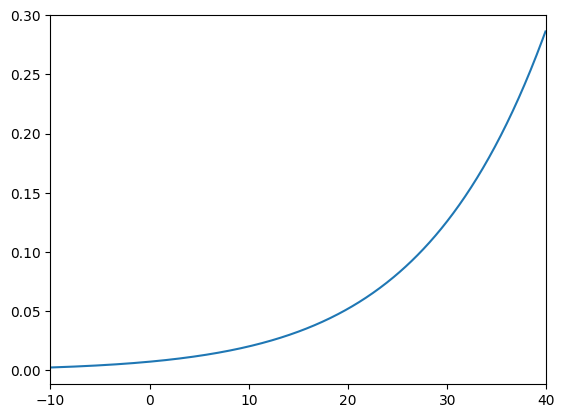

In [59]:
xs  = [i/10 for i in range(-100,400)]
plt.plot(xs, [r_v_v(x) for x in xs])
plt.xlim(-10,40)
plt.show()

In [60]:
initial_T = temperature_M[:,0] # initial temperature

In [61]:
mos_per = 0.02 # number of mosquitos per person (to be optimized)
a = 0.4 # mosquito bites per day (to be optimized)

K = pops*mos_per # carrying capacity of mosquitos
r_h = 0.5 # 1/r_h: average human incubation period
sigma_h = 0.25 # 1/sigma_h: average infection period
c = 1
f = 1

initial_T = temperature_M[:,0] # initial temperature
# WARNING: something strange: too many mosquitos
Q0 = E_v_a(initial_T)/(E_v_a(initial_T)+U_v_a(initial_T))*c*f*theta_v_v(initial_T)/U_v_v(initial_T)
current_mos_Aqua = K*(1-1/Q0) # aquatic mosquitos
current_mos_Adul = K*(1-1/Q0)*E_v_a(initial_T)/U_v_v(initial_T) # adult femal mosquitos

In [62]:
current_mos_Aqua+current_mos_Adul

array([271279.27504881, 152351.48687325, 176860.61273004, 150032.91535237,
       166913.69491837, 198118.88961196,  76479.82131549, 171618.82409376,
       204776.63238581,  96855.95492765, 191910.8592893 ,  79284.43917139,
       138038.28285043,  83406.67753015, 158562.26093885,  86707.25247386,
       374895.45259047, 250082.27980924, 117278.41600458, 149887.49692636,
       214300.07959014, 193303.54565576, 200299.25219225, 288262.72126957,
       151199.2879904 , 123448.68425137, 127772.58586754, 156661.70626267,
        80747.46949008,  43675.57321519, 183817.79373096,  65268.38897891,
       142026.09215108, 200045.98470099, 255018.26858563, 128946.78593089,
       118739.42044881,  70551.96326137,   4598.47157992, 201637.92174227,
       144642.59410573, 116302.70527524, 278335.50001862, 115672.30941129,
        45983.85166244,  85872.15169155, 122184.46719629,  73768.44493749,
        65361.06319218, 178908.7128433 , 153359.91960875,  94512.48065813,
       166478.24052861, 1

In [63]:
pops

array([2768908.06002472, 1555029.44293915, 1805190.52183771,
       1531364.12102782, 1703663.7800835 , 2295845.69050176,
        803279.15101158, 1988757.04621787, 2372997.09229766,
        986867.86345571, 2015668.8322256 ,  918765.6883803 ,
       1449836.99945882,  851319.81288122, 1618421.90948909,
        885008.30074197, 3826503.29686111, 2552553.41606378,
       1197043.71549792, 1529879.85632763, 2187329.70859757,
       1987230.74097543, 2004647.20339761, 2876611.25811197,
       1508837.3971359 , 1231910.50633466, 1275059.28399574,
       1610539.30781618,  822738.08311168,  437116.53810166,
       1839696.46468676,  666184.94271636, 1449639.64246879,
       2041840.23757249, 2602934.33478565, 1316141.06832926,
       1375978.77347293,  720113.61608746,   46935.9298426 ,
       2058088.90715425, 1476345.8969366 , 1187084.77815473,
       2777546.22366538, 1214923.79167776,  472730.71635628,
        874953.60438586, 1244940.73884819,  752943.77621049,
        667130.85491711,